In [1]:
import zipfile

# Path to your downloaded zip file
zip_file_path = "/content/realwaste.zip"
# Path to extract the data
extract_dir = "/content/data"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List directories to ensure extraction is successful
print(f"Extracted to: {extract_dir}")


Extracted to: /content/data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Define dataset paths
dataset_path = "/content/data/realwaste-main/RealWaste"

# Create dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.75 * len(dataset))  # 75% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



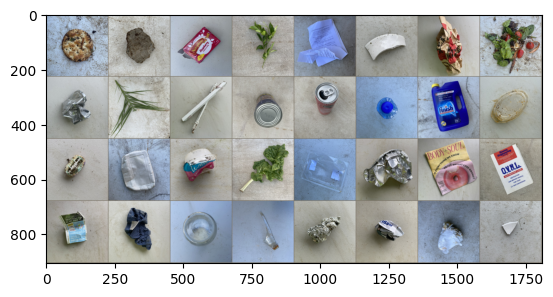

Labels: tensor([1, 4, 0, 8, 5, 4, 5, 1, 3, 8, 4, 3, 3, 6, 6, 6, 4, 0, 4, 1, 6, 3, 5, 5,
        5, 7, 2, 2, 3, 5, 4, 4])


In [3]:
# Function to unnormalize and display images
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels)


In [4]:
import torch
import torch.nn as nn

class TrashNetCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrashNetCNN, self).__init__()
        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions by half

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # Adjusted flattened size for deeper architecture
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout and activation
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with ReLU, BatchNorm, and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))

        # Flatten the output
        x = x.view(-1, 512 * 7 * 7)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)      # Final output layer
        return x


In [6]:
# Instantiate the model
num_classes = len(dataset.classes)  # Number of classes based on folder structure
model = TrashNetCNN(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [7]:
device

device(type='cuda')



# For Learning Rate 0.001

In [8]:
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [9]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Train the model over the epochs using the training loader and validate with the validation loader
    Args:
        model: Neural Network model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        epochs: Number of epochs
    """
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

        # Adjust learning rate (if scheduler is used)
        if scheduler:
            scheduler.step()

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Final evaluation for precision, recall, and confusion matrix
    print("\nFinal Evaluation on Validation Set:")
    final_loss, final_acc, final_precision, final_recall, final_conf_matrix = evaluate_model(model, val_loader, criterion, device)
    print(f"Final Loss: {final_loss:.4f}, Final Accuracy: {final_acc:.2f}%")
    print(f"Final Precision: {final_precision:.4f}")
    print(f"Final Recall: {final_recall:.4f}")
    print("Final Confusion Matrix:")
    print(final_conf_matrix)

    return final_loss, final_acc, final_precision, final_recall, final_conf_matrix

# Evaluation function for validation/testing
def evaluate_model(model, loader, criterion, device):
    """
    Function to compute average loss and accuracy during validation/testing
    Args:
        model: Trained model
        loader: DataLoader for validation or testing
        criterion: The loss function
    Returns:
        val_loss: Average validation loss
        val_acc: Accuracy on validation data
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Compute loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Average loss over all validation batches
    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Precision and Recall calculation
    # Avoid division by zero errors
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(conf_matrix) / np.maximum(np.sum(conf_matrix, axis=1), 1e-7)  # Row-wise sums for precision
        recall = np.diag(conf_matrix) / np.maximum(np.sum(conf_matrix, axis=0), 1e-7)  # Column-wise sums for recall

    val_precision = np.mean(precision)  # Mean precision across all classes
    val_recall = np.mean(recall)  # Mean recall across all classes

    # Log results
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Return results
    model.train()
    return val_loss, val_acc, val_precision, val_recall, conf_matrix



In [10]:
def test_model(model, test_loader, device):
    """
    Evaluate accuracy on the test data
    Args:
        model: Trained model
        test_loader: Test DataLoader
    Returns:
        None
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    cnn_accuracy=100 * correct / total
    print(f"Test Accuracy: {cnn_accuracy:.2f}%")
    model.train()


In [11]:
val_losses, val_accuracies,val_precision,val_recall,conf_matrix = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40)

Epoch [1/40], Loss: 2.3721
Validation Loss: 1.6845, Validation Accuracy: 37.92%
Epoch [1/40] - Validation Loss: 1.6845, Validation Accuracy: 37.92%
Epoch [2/40], Loss: 1.5638
Validation Loss: 1.3806, Validation Accuracy: 57.16%
Epoch [2/40] - Validation Loss: 1.3806, Validation Accuracy: 57.16%
Epoch [3/40], Loss: 1.3983
Validation Loss: 1.3840, Validation Accuracy: 51.69%
Epoch [3/40] - Validation Loss: 1.3840, Validation Accuracy: 51.69%
Epoch [4/40], Loss: 1.3178
Validation Loss: 1.1884, Validation Accuracy: 60.25%
Epoch [4/40] - Validation Loss: 1.1884, Validation Accuracy: 60.25%
Epoch [5/40], Loss: 1.2550
Validation Loss: 1.1333, Validation Accuracy: 60.53%
Epoch [5/40] - Validation Loss: 1.1333, Validation Accuracy: 60.53%
Epoch [6/40], Loss: 1.1708
Validation Loss: 1.0594, Validation Accuracy: 62.08%
Epoch [6/40] - Validation Loss: 1.0594, Validation Accuracy: 62.08%
Epoch [7/40], Loss: 1.1105
Validation Loss: 1.0246, Validation Accuracy: 61.80%
Epoch [7/40] - Validation Loss: 

In [12]:
test_model(model, test_loader, device)
torch.save(model.state_dict(), "trashnet_cnn.pth")

Test Accuracy: 79.20%


# For Learning Rate:0.0001

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

In [14]:
val_losses, val_accuracies,val_precision,val_recall,conf_matrix = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40)

Epoch [1/40], Loss: 0.2178
Validation Loss: 0.6326, Validation Accuracy: 81.60%
Epoch [1/40] - Validation Loss: 0.6326, Validation Accuracy: 81.60%
Epoch [2/40], Loss: 0.1815
Validation Loss: 0.5864, Validation Accuracy: 82.30%
Epoch [2/40] - Validation Loss: 0.5864, Validation Accuracy: 82.30%
Epoch [3/40], Loss: 0.1643
Validation Loss: 0.5957, Validation Accuracy: 82.30%
Epoch [3/40] - Validation Loss: 0.5957, Validation Accuracy: 82.30%
Epoch [4/40], Loss: 0.1618
Validation Loss: 0.5985, Validation Accuracy: 81.88%
Epoch [4/40] - Validation Loss: 0.5985, Validation Accuracy: 81.88%
Epoch [5/40], Loss: 0.1449
Validation Loss: 0.6191, Validation Accuracy: 82.30%
Epoch [5/40] - Validation Loss: 0.6191, Validation Accuracy: 82.30%
Epoch [6/40], Loss: 0.1427
Validation Loss: 0.6196, Validation Accuracy: 81.60%
Epoch [6/40] - Validation Loss: 0.6196, Validation Accuracy: 81.60%
Epoch [7/40], Loss: 0.1311
Validation Loss: 0.5994, Validation Accuracy: 83.01%
Epoch [7/40] - Validation Loss: 

In [15]:
test_model(model, test_loader, device)

Test Accuracy: 82.14%


In [16]:
# Predict a single image
def predict_image(model, img_path, transform, labels):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = labels[predicted.item()]
        probabilities = torch.softmax(output, dim=1).squeeze()

    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({torch.max(probabilities).item()*100:.2f}%)")
    plt.show()

    return probabilities.cpu().numpy(), labels[predicted.item()]

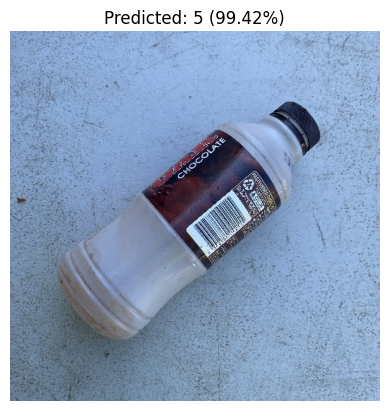

Predicted class: 5
Class Probabilities:
1: 0.05%
4: 0.02%
0: 0.01%
8: 0.42%
5: 0.03%
4: 0.05%
5: 99.42%
1: 0.00%
3: 0.00%


In [17]:
# Test the prediction
test_img_path = "/content/data/realwaste-main/RealWaste/Plastic/Plastic_10.jpg"
probabilities, predicted_class = predict_image(model, test_img_path, transform, labels)

print(f"Predicted class: {predicted_class}")
print("Class Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"{labels[i]}: {prob * 100:.2f}%")

# Using SVM

In [18]:
import torch, torchvision
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from torchvision.models import ResNet50_Weights

# Load a pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight=ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=weight).to(device)
resnet.fc = torch.nn.Identity()  # Remove the final fully connected layer to get feature vectors

def extract_features(loader, model, device):
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            # Extract features
            outputs = model(images)
            features.append(outputs.cpu())
            labels.append(targets)

    # Concatenate all features and labels into a single array
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels

# Extract features for training and testing datasets
train_features, train_labels = extract_features(train_loader, resnet, device)
test_features, test_labels = extract_features(test_loader, resnet, device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.3MB/s]


In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Encode class labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Train an SVM
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(train_features, train_labels_encoded)

# Predict on test data
test_predictions = svm_model.predict(test_features)

# Calculate accuracy
svm_accuracy = accuracy_score(test_labels_encoded, test_predictions)*100
print("Test Accuracy:", svm_accuracy)


Test Accuracy: 86.97478991596638


In [20]:
# Calculate precision, recall, and confusion matrix
precision = precision_score(test_labels_encoded, test_predictions, average='weighted')
recall = recall_score(test_labels_encoded, test_predictions, average='weighted')
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

print("Precision:", precision*100)
print("Recall:", recall*100)
print("Confusion Matrix:\n", conf_matrix)

Precision: 87.14060575191391
Recall: 86.97478991596638
Confusion Matrix:
 [[36  0  0  3  1  2  3  0  0]
 [ 0 41  0  0  1  0  0  0  1]
 [ 0  0 42  1  0  0  1  0  0]
 [ 4  0  0 68  1  0  3  0  0]
 [ 0  2  0  2 45  0  2  4  1]
 [ 3  0  0  1  4 50  2  0  0]
 [ 0  0  7  6  4  0 68  0  0]
 [ 0  0  0  0  1  0  0 30  0]
 [ 0  2  0  0  0  0  0  0 34]]
